# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [ ]:
import torch
import httpx
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import AdamW
from typing import Optional, List, Type
from dataclasses import dataclass, field
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer

## Downloading Dataset

In [15]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Character-based encoding

`SimpleCharTokenizer` implementa un tokenizador simple basado en caracteres individuales. Su prop√≥sito es transformar texto plano en una secuencia de IDs num√©ricos (tokens) y viceversa, lo cual es necesario para poder alimentar texto al modelo TinyGPT.

#### Funcionamiento:

- Al inicializar el tokenizador con un corpus (`text`), se construye un vocabulario √∫nico a partir de todos los caracteres distintos presentes en el texto.
- Se definen dos diccionarios:
  - `stoi` (string to index): asigna a cada car√°cter su √≠ndice √∫nico.
  - `itos` (index to string): permite recuperar el car√°cter original desde su √≠ndice.
- El m√©todo `encode(text_string)` convierte una cadena en una lista de IDs enteros, uno por car√°cter.
- El m√©todo `decode(token_ids)` reconstruye la cadena original a partir de una lista de IDs.

> **Nota:** Este enfoque es limitado ya que trabaja a nivel de caracteres sin entender palabras, contextos ni estructuras gramaticales.

In [ ]:
class SimpleCharTokenizer:
    """
    A simple character-level tokenizer that handles encoding and decoding.
    This class builds a vocabulary from a given text and provides methods
    to convert strings to token IDs and vice-versa.
    """
    def __init__(self, text: str):
        """
        Initializes the tokenizer and builds the vocabulary.

        Args:
            text (str): The corpus to build the vocabulary from.
        """
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.stoi = {char: i for i, char in enumerate(self.chars)}
        self.itos = {i: char for char, i in self.stoi.items()}

    def encode(self, text_string: str) -> list[int]:
        """
        Encodes a string into a list of integer token IDs.

        Args:
            text_string (str): The input string to encode.

        Returns:
            list[int]: A list of corresponding token IDs.
        """
        return [self.stoi[char] for char in text_string]

    def decode(self, token_ids: list[int]) -> str:
        """
        Decodes a list of integer token IDs back into a string.

        Args:
            token_ids (list[int]): The list of token IDs to decode.

        Returns:
            str: The resulting decoded string.
        """
        return ''.join([self.itos[token_id] for token_id in token_ids])

In [ ]:
tokenizer = SimpleCharTokenizer(text)

vocab_size = tokenizer.vocab_size
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

## GPT Configuration

#### `MoEArgs`

Define los par√°metros espec√≠ficos para una capa **Mixture of Experts (MoE)**:
- `num_experts`: cantidad total de expertos disponibles.
- `num_experts_per_token`: n√∫mero de expertos que se activan por cada token de entrada.

Estos par√°metros ser√°n utilizados para controlar c√≥mo se enrutan los tokens a los distintos expertos durante el forward pass.

In [ ]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


#### `GPTConfig`

Es la configuraci√≥n principal del modelo GPT:
- `block_size`: tama√±o de la secuencia de entrada (ventana de contexto).
- `batch_size`: cantidad de muestras por batch.
- `n_embd`: dimensi√≥n de los embeddings.
- `n_head`: n√∫mero de *heads* de atenci√≥n en cada capa.
- `n_layer`: cantidad de capas transformer.
- `dropout`: proporci√≥n de *dropout* aplicada durante el entrenamiento.
- `vocab_size`: tama√±o del vocabulario (debe coincidir con el tokenizador).
- `bias`: indica si se usan biases en las capas lineales.
- `ff_class`: clase opcional que define la capa feed-forward (permite usar una capa MoE).
- `moe`: objeto `MoEArgs` que habilita y parametriza una capa MoE.

In [ ]:
@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

In [ ]:
config = GPTConfig()
print(config.__dict__)

## Creaci√≥n de datasets y dataloaders

La clase `CharDataset` define un `Dataset` custom de PyTorch para entrenar modelos de lenguaje autoregresivos a nivel car√°cter. Recibe como entrada un `Tensor` unidimensional con los IDs de tokens (generados por el tokenizador) y construye pares entrada-objetivo adecuados para entrenamiento.

#### Funcionamiento:

- **Inicializaci√≥n (`__init__`)**:  
  Se recibe el corpus como un `Tensor` de IDs de caracteres (`data`) y un `block_size` que define el tama√±o de ventana de contexto que se le mostrar√° al modelo.

- **Longitud (`__len__`)**:  
  Calcula cu√°ntas secuencias de entrenamiento se pueden extraer del corpus. Como cada par entrada-objetivo usa `block_size + 1` posiciones, el total de muestras posibles es `len(data) - block_size`.

- **Acceso a muestras (`__getitem__`)**:  
  Dado un √≠ndice `idx`, se devuelve un par:
  - `x`: secuencia de entrada de longitud `block_size`.
  - `y`: misma secuencia desplazada una posici√≥n a la derecha, que representa el objetivo de predicci√≥n siguiente car√°cter a car√°cter.

Este esquema es est√°ndar para tareas de modelado de lenguaje autoregresivo, donde se entrena al modelo para predecir el pr√≥ximo token dado un historial previo.

In [ ]:
class CharDataset(Dataset):
    """
    A PyTorch Dataset for character-level language modeling.

    This dataset takes a long sequence of token IDs and creates overlapping
    input-target pairs of a specified block size, suitable for training
    autoregressive language models.
    """
    def __init__(self, data: torch.Tensor, block_size: int):
        """
        Initializes the dataset.

        Args:
            data (torch.Tensor): A 1D tensor of token IDs representing the entire corpus.
            block_size (int): The sequence length for each input sample (context window).
        """
        self.data = data
        self.block_size = block_size

    def __len__(self):
        """
        Returns the total number of possible sequences in the dataset.

        The length is calculated as the total number of tokens minus the `block_size`.
        This is because the `__getitem__` method needs to access up to index
        `idx + block_size` for the input `x` and `idx + block_size + 1` for the target `y`.
        Subtracting `block_size` ensures that even for the last possible `idx`, we do
        not go out of bounds when creating a sample.
        """
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.

        Each sample consists of an input sequence (x) and a target sequence (y).
        The target sequence is the input sequence shifted by one position to the right,
        which is the standard for next-token prediction tasks.

        Args:
            idx (int): The starting index of the sequence in the data tensor.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the input
            tensor (x) and the target tensor (y).
        """
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

#### Datasets

Se instancian dos objetos `CharDataset`, uno para entrenamiento (`train_dataset`) y otro para validaci√≥n (`val_dataset`), utilizando los tensores `train_data` y `val_data` junto con el tama√±o de ventana `block_size` definido en `config`.

In [ ]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

#### DataLoaders

Se crean `train_loader` y `val_loader`, que son los iteradores utilizados durante el entrenamiento del modelo:

- `batch_size`: se toma de la configuraci√≥n (`config.batch_size`).
- `shuffle`: activado para entrenamiento (mezcla aleatoria de secuencias), desactivado para validaci√≥n (evaluaci√≥n determinista).
- `drop_last`: descarta el √∫ltimo batch si es incompleto.
- `pin_memory`: acelera la transferencia de datos al GPU.
- `num_workers`: n√∫mero de subprocesos para cargar datos.

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers= 8, # if using mps set num_workers as 0.
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers= 8,
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## M√≥dulo `AttentionHead`: Scaled Dot-Product

Este m√≥dulo implementa una **cabeza de atenci√≥n** individual del mecanismo de atenci√≥n m√∫ltiple (*Multi-Head Attention*) de los Transformers. Es la unidad b√°sica encargada de calcular **atenci√≥n causal** sobre una secuencia, lo que permite que cada token "observe" otros tokens anteriores y as√≠ incorporar contexto.

#### Fundamento te√≥rico

La atenci√≥n por producto punto escalado es una funci√≥n que toma tres vectores por token: `query`, `key`, y `value`. La atenci√≥n se calcula como:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

Donde:

- $Q \in \mathbb{R}^{T \times d_k}$: vector de consulta.
- $K \in \mathbb{R}^{T \times d_k}$: vector clave.
- $V \in \mathbb{R}^{T \times d_v}$: vector valor.
- $d_k$: dimensi√≥n de las keys, se utiliza para escalar el producto punto y evitar gradientes explosivos.\\
- $T$: longitud de la secuencia.

En GPT, usamos atenci√≥n *causal*: cada token s√≥lo puede "ver" a los tokens anteriores (no a los futuros), lo que se aplica con una **m√°scara triangular inferior**.

#### Implementaci√≥n paso a paso

- **Inicializaci√≥n (`__init__`)**:
  - `head_dim`: dimensi√≥n interna de esta cabeza de atenci√≥n (es decir, una fracci√≥n de `n_embd`).
  - `key_query_value`: proyecci√≥n lineal que genera de forma conjunta los tres vectores necesarios (`k`, `q`, `v`) a partir de la entrada.
  - `dropout`: regularizaci√≥n aplicada sobre los pesos de atenci√≥n.
  - `tril`: m√°scara triangular inferior ($ \text{tril}(1) $) para forzar atenci√≥n causal.

- **Forward pass (`forward`)**:
  1. `x` es de forma `(B, T, C)`, donde:
    - `B` es el tama√±o del batch (cantidad de secuencias procesadas en paralelo),
    - `T` es la longitud de cada secuencia (n√∫mero de tokens, igual a `block_size`),
    - `C` es la dimensi√≥n del embedding para cada token (igual a `n_embd`).

  2. Se proyecta `x` a los tres espacios: keys (`k`), queries (`q`) y values (`v`), con una sola capa lineal.
  3. Si se proporciona una `kv_cache`, se concatenan las nuevas claves/valores con las almacenadas previamente (√∫til para generaci√≥n autoregresiva eficiente).
  4. Se calcula el producto punto escalado ($qk^\top / \sqrt{d_k}$) ‚Üí genera una matriz de pesos de atenci√≥n.
  5. Se aplica la m√°scara para atenci√≥n causal: impide que cada posici√≥n atienda a posiciones futuras.
  6. Se aplica `softmax` y `dropout` para normalizar y regularizar los pesos.
  7. Finalmente, se multiplican los pesos por los valores para obtener la salida de atenci√≥n: una representaci√≥n contextualizada de cada token.

- **Salidas**:
  - Si `return_weights=True`, devuelve tambi√©n los pesos de atenci√≥n (√∫til para visualizaci√≥n).
  - Si se usa `kv_cache`, tambi√©n devuelve el nuevo cache (necesario para inferencia paso a paso en generaci√≥n de texto).
  - En caso contrario, devuelve s√≥lo la salida de atenci√≥n.

In [ ]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

#### Flujo de datos en cabeza de atenci√≥n:

1. **Entrada completa**:  
   Cada token entra al sistema como un vector completo de dimensi√≥n `n_embd`.  
   Por ejemplo, si `n_embd = 64`, cada token es un vector de 64 valores.

2. **Proyecci√≥n a Q, K, V**:  
   A trav√©s de una capa lineal (`nn.Linear`), cada token se transforma en tres vectores:
   - `query`
   - `key`
   - `value`  
   Todos de dimensi√≥n `n_embd`.

3. **Divisi√≥n entre cabezas**:  
   Luego, estos vectores se **dividen entre las `n_head` cabezas** de atenci√≥n:
   - Cada cabeza recibe una **fracci√≥n del espacio transformado**, no del embedding original.
   - La dimensi√≥n por cabeza es:  
      $$
      \text{head\_dim} = \frac{n\_embd}{n\_head}
      $$

4. **Atenci√≥n sobre la secuencia**:  
   Cada cabeza hace atenci√≥n **entre todos los tokens de la secuencia**, pero **usando s√≥lo su subespacio** (`head_dim`) para cada token.  
   Es decir, **cada token es atendido completamente por cada cabeza**, pero desde una perspectiva distinta del espacio de representaci√≥n.

#### ¬øPor qu√© se hace esto?

- Para permitir que distintas cabezas aprendan **patrones complementarios**.
- Para distribuir el costo computacional: en lugar de hacer una sola atenci√≥n de gran dimensi√≥n, se hacen varias en paralelo de menor dimensi√≥n.
- Por eso es necesario cumplir:

  ```python
  assert n_embd % n_head == 0
  ```

  Ya que cada cabeza debe recibir una fracci√≥n entera de la dimensi√≥n total.

Cada cabeza ve **todos los tokens**, pero en **distinto subespacio**.

## M√≥dulo `MultiHeadAttention`

Este componente implementa el mecanismo de **atenci√≥n multi-cabeza** del Transformer. La idea te√≥rica es aplicar varias cabezas de atenci√≥n en paralelo para capturar distintas relaciones entre tokens desde diferentes subespacios de representaci√≥n.

> **Importante:** en esta implementaci√≥n, las cabezas **no se computan en paralelo** sino **de forma secuencial** mediante un bucle `for`. Esto mejora la claridad del c√≥digo, pero **no es eficiente** para uso en producci√≥n. En implementaciones reales (como Hugging Face), se vectoriza todo el c√°lculo para que las cabezas se procesen simult√°neamente.

#### ¬øQu√© hace este m√≥dulo?

- Crea m√∫ltiples instancias del m√≥dulo `AttentionHead`, una por cada cabeza definida en `n_head`.
- Cada cabeza realiza atenci√≥n de forma independiente sobre toda la secuencia.
- Las salidas de todas las cabezas se concatenan y se proyectan nuevamente al espacio de dimensi√≥n completa `n_embd`.

#### Paso a paso del `__init__`

1. **Verificaci√≥n de divisibilidad**:  
   Se asegura que `n_embd` pueda dividirse equitativamente entre `n_head`, para calcular la dimensi√≥n de cada cabeza (`head_dim`).
2. **Creaci√≥n de las cabezas de atenci√≥n**:  
   Se construye una `nn.ModuleList` con `n_head` instancias de `AttentionHead`.
3. **Proyecci√≥n final**:  
   Una capa lineal (`self.proj`) toma el vector concatenado de todas las cabezas y lo proyecta de vuelta a la dimensi√≥n original (`n_embd`).  
   Esto permite mezclar la informaci√≥n aprendida por cada cabeza.
4. **Dropout final**:  
   Regularizaci√≥n aplicada a la salida final para mitigar overfitting.

#### Paso a paso del `forward`

##### Entradas:
- `x`: secuencia de tokens embebida, de forma `(B, T, n_embd)`.
- `kv_cache`: opcional, para reutilizar las claves/valores de pasos anteriores (modo generaci√≥n).
- `return_weights`: si se activa, tambi√©n devuelve los pesos de atenci√≥n por cabeza.

##### Proceso:
1. Se itera sobre cada cabeza (`self.heads`):
   - Cada cabeza recibe la secuencia completa.
   - Produce una salida de atenci√≥n `out` para esa cabeza.
   - (Opcional) Se acumulan los pesos de atenci√≥n y los nuevos cach√©s de `k/v` si corresponde.
2. Las salidas individuales de todas las cabezas (`out`) se **concatenan a lo largo de la dimensi√≥n de embedding**:
   $$
   \text{concat} \in \mathbb{R}^{B \times T \times n\_embd}
   $$
3. Se aplica la proyecci√≥n lineal final y el dropout.

##### Salidas:
- La salida principal tiene forma `(B, T, n_embd)`.
- Si `return_weights=True`, tambi√©n devuelve los pesos de atenci√≥n por cabeza (`[n_head, B, T, T]`).
- Si hay `kv_cache`, tambi√©n devuelve el nuevo cach√© para reutilizaci√≥n.

#### ¬øPor qu√© usar m√∫ltiples cabezas?

- **Diversidad de representaciones**: cada cabeza ve la misma secuencia, pero en un subespacio diferente (porci√≥n del embedding), y por lo tanto puede aprender a detectar relaciones diferentes entre tokens.
- **Paralelismo**: se computan todas las cabezas simult√°neamente, lo que es eficiente en hardware moderno.
- **Potencia expresiva**: concatenar las salidas de distintas cabezas produce una representaci√≥n m√°s rica y contextualizada de cada token.

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

# Continue from here!

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [ ]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [ ]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return tokenizer.decode(idx[0].tolist())

# Setup

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [ ]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0716 05:12:54.109000 2241 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_indu

Epoch 1 training loss: 2.0821


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.09743: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1246/1246 [00:09<00:00, 134.14it/s]


Epoch 1 validation loss: 2.0587


loss 2.12373: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11246/11246 [03:15<00:00, 57.61it/s]


Epoch 2 training loss: 2.1207


val_loss 2.09742: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1246/1246 [00:09<00:00, 132.81it/s]

Epoch 2 validation loss: 2.0587
Training complete.


### Quick test 

In [ ]:
generate("To be", max_new_tokens=100,use_cache=True) 

"To be!\n\nThaly I hat 't, them is would thand ave xicis ppris tiunke swieng ehame the ink ange hierecise no"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [15]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:

    return None

## Compare generate vs generateV2

Add your comments and findings

In [17]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [ ]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return None


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [19]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:


        return None

In [ ]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [29]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [30]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [ ]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [ ]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [31]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


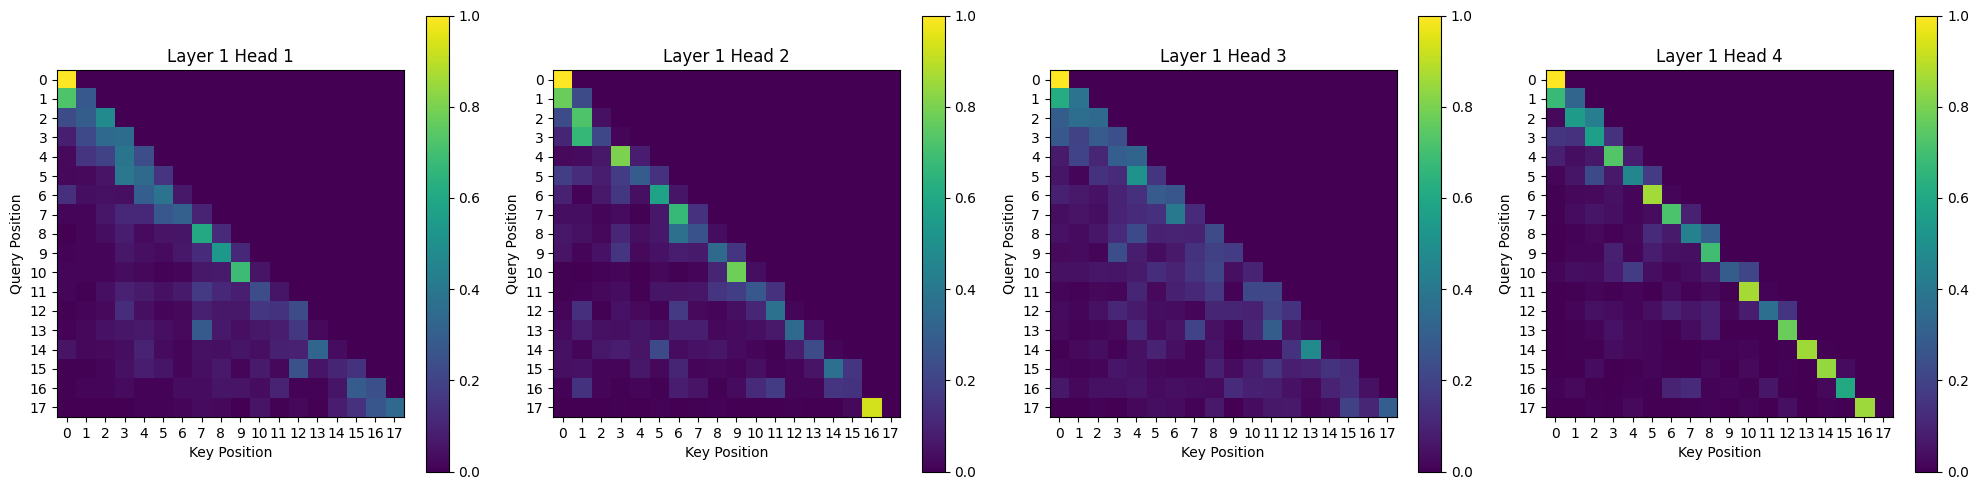

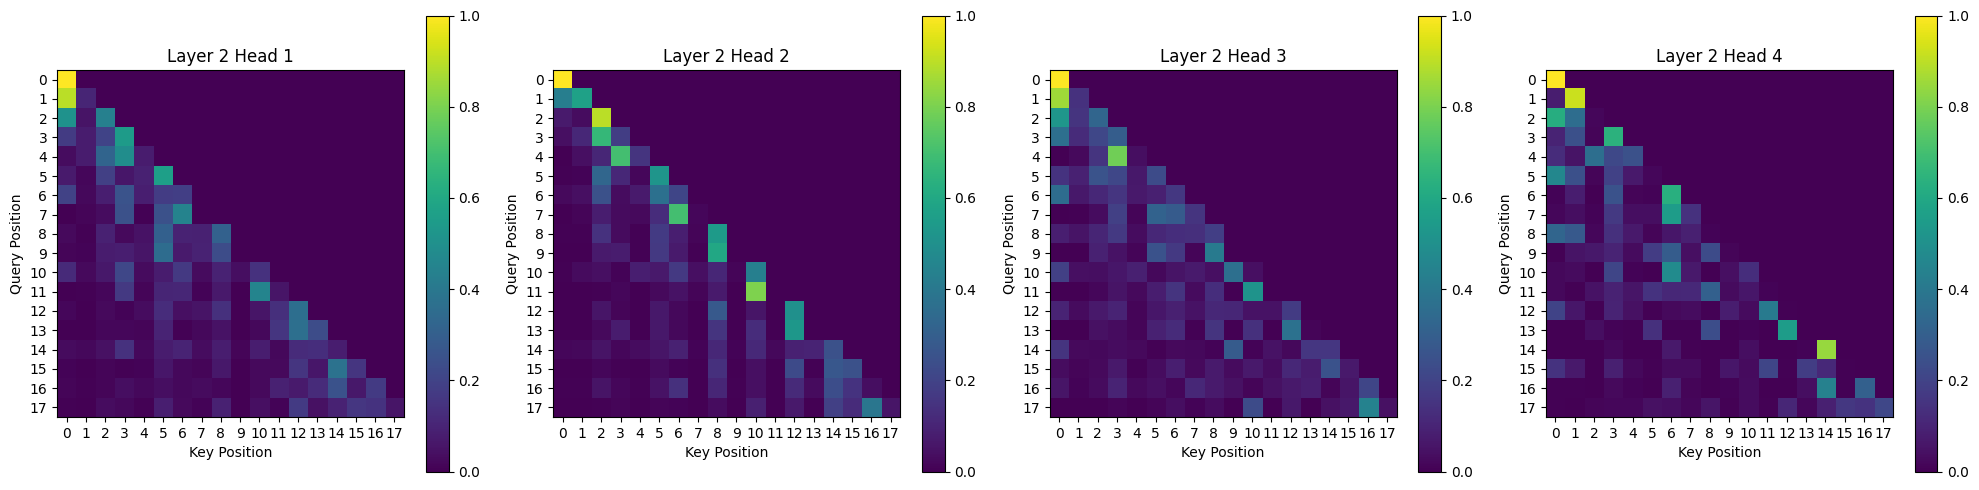

In [32]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusions

- 
- 

# Congratulations! üéâ

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

